<a href="https://colab.research.google.com/github/jerovernay/tp-Alc/blob/main/codigo/TP1_template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Carga de paquetes necesarios para graficar
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # Para leer archivos
import geopandas as gpd # Para hacer cosas geográficas
import seaborn as sns # Para hacer plots lindos
import networkx as nx # Construcción de la red en NetworkX
import scipy


# Preambulo

En esta sección cargamos los datos y los visualizamos. También construimos la matriz de adyacencia de la red de museos.

## Carga de datos de los museos

El listado de los museos, con el que se construye el [mapa](https://mapas.museosabiertos.org/museos/caba/), lo podemos encontrar [acá](https://github.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/blob/principal/data/export.geojson?short_path=bc357f3). También descargamos los barrios de CABA como complemento para los gráficos.

In [2]:
# Leemos el archivo, retenemos aquellos museos que están en CABA, y descartamos aquellos que no tienen latitud y longitud
museos = gpd.read_file('https://raw.githubusercontent.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/refs/heads/principal/data/export.geojson')
barrios = gpd.read_file('https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-educacion/barrios/barrios.geojson')

## Visualización

<Axes: >

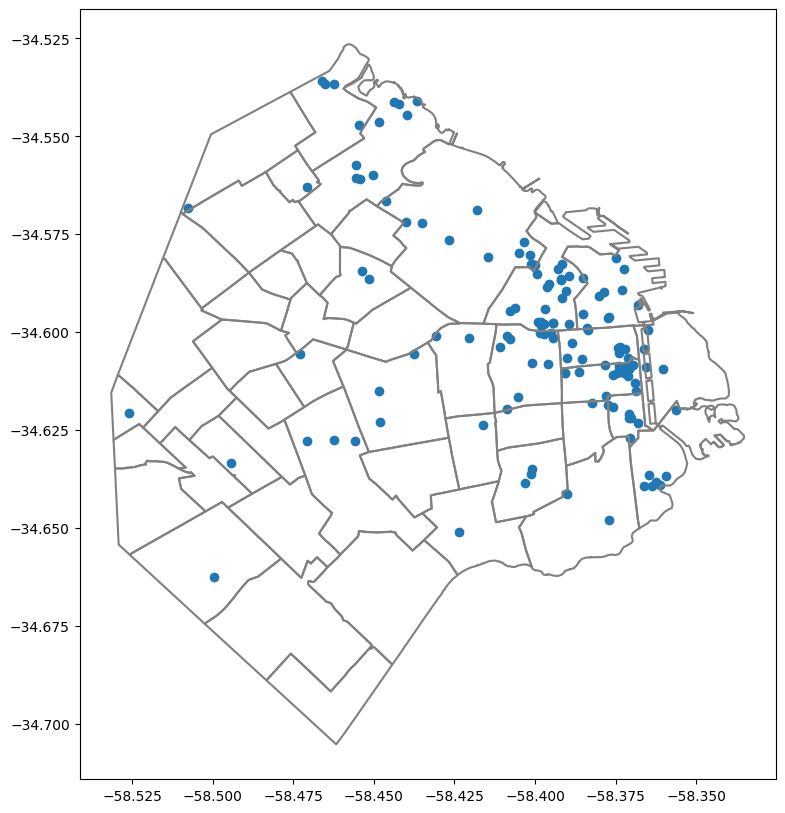

In [3]:
# Armamos el gráfico para visualizar los museos
fig, ax = plt.subplots(figsize=(10, 10))
barrios.boundary.plot(color='gray',ax=ax)
museos.plot(ax=ax)

## Cálculo de la matriz de distancias

Ahora construimos la matriz de distancias entre todos los museos. Como la tierra es un [geoide](https://es.wikipedia.org/wiki/Geoide) (es decir que no es [plana](https://es.wikipedia.org/wiki/Terraplanismo)), el cálculo de distancias no es una operación obvia. Una opción es proyectar a un [sistema de coordenadas local](https://geopandas.org/en/stable/docs/user_guide/projections.html), de forma tal que las distancias euclideas se correspondan con las distancias en metros. En este notebook usamos [EPSG](https://en.wikipedia.org/wiki/EPSG_Geodetic_Parameter_Dataset) 22184.

In [4]:
# En esta línea:
# Tomamos museos, lo convertimos al sistema de coordenadas de interés, extraemos su geometría (los puntos del mapa),
# calculamos sus distancias a los otros puntos de df, redondeamos (obteniendo distancia en metros), y lo convertimos a un array 2D de numpy
D = museos.to_crs("EPSG:22184").geometry.apply(lambda g: museos.to_crs("EPSG:22184").distance(g)).round().to_numpy()

### Matriz de adyacencia: construimos una matriz conectando a cada museo con los $m$ más cercanos

In [5]:
def construye_adyacencia(D,m):
    # Función que construye la matriz de adyacencia del grafo de museos
    # D matriz de distancias, m cantidad de links por nodo
    # Retorna la matriz de adyacencia como un numpy.
    D = D.copy()
    l = [] # Lista para guardar las filas
    for fila in D: # recorriendo las filas, anexamos vectores lógicos
        l.append(fila<=fila[np.argsort(fila)[m]] ) # En realidad, elegimos todos los nodos que estén a una distancia menor o igual a la del m-esimo más cercano
    A = np.asarray(l).astype(int) # Convertimos a entero
    np.fill_diagonal(A,0) # Borramos diagonal para eliminar autolinks
    return(A)

m = 3 # Cantidad de links por nodo
A = construye_adyacencia(D,m)

## Construcción de la red en NetworkX (sólo para las visualizaciones)

In [6]:
G = nx.from_numpy_array(A) # Construimos la red a partir de la matriz de adyacencia
# Construimos un layout a partir de las coordenadas geográficas
G_layout = {i:v for i,v in enumerate(zip(museos.to_crs("EPSG:22184").get_coordinates()['x'],museos.to_crs("EPSG:22184").get_coordinates()['y']))}

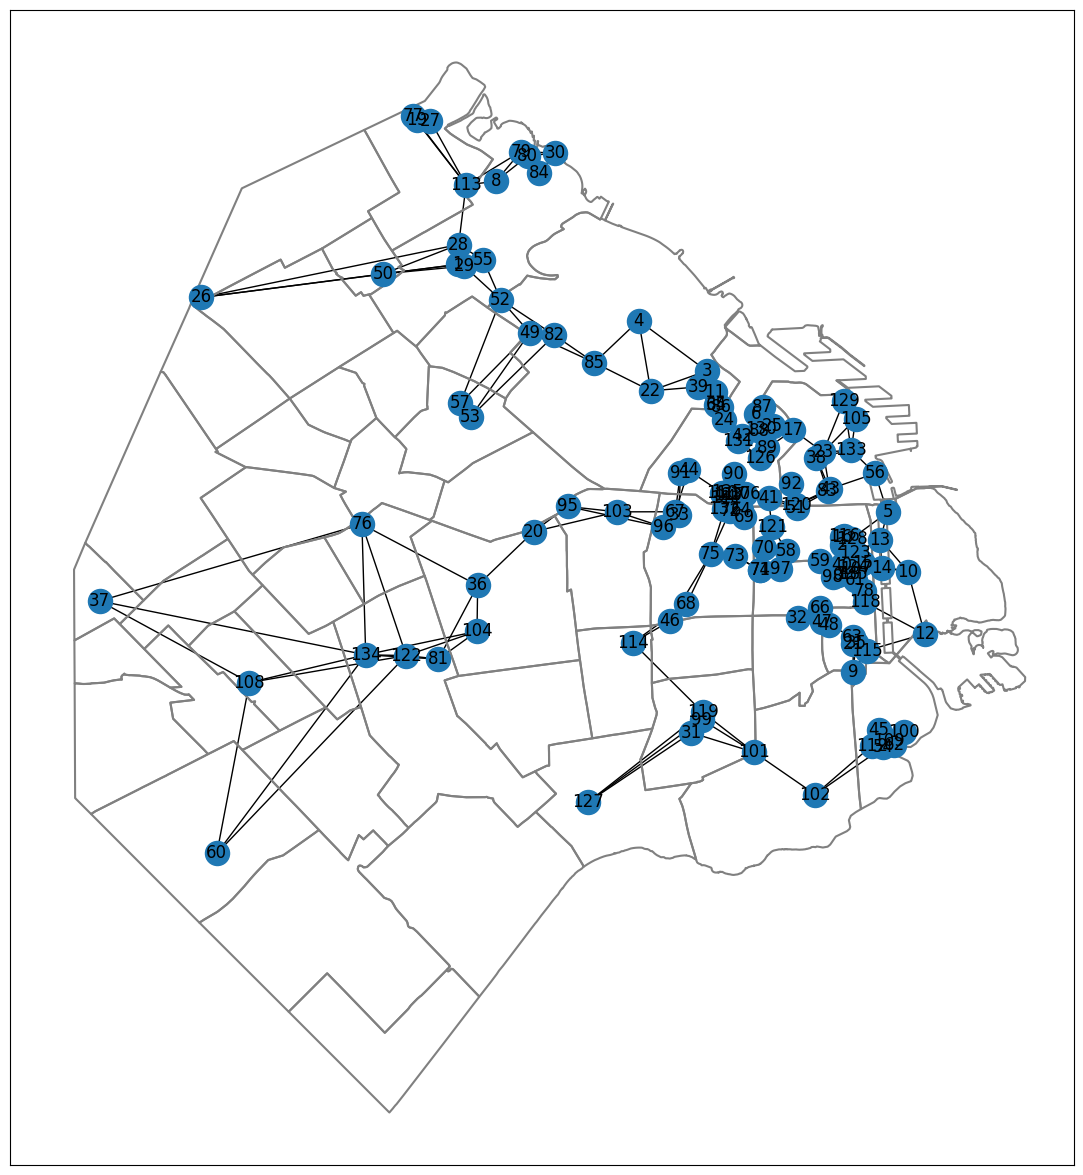

In [7]:
fig, ax = plt.subplots(figsize=(15, 15)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
nx.draw_networkx(G,G_layout,ax=ax) # Graficamos los museos

# Resolución del TP

Aquí empieza la aventura... ¡diviertanse y consulten lo que necesiten!

# Punto 1: TERMINADO

##Resolucion

Tenemos que probar la igualdad:

$$
M ⋅ p = B
$$

donde:

$$
M = \frac{N}{\alpha} \left( I - (1 - \alpha) \; C \right) \quad \text {y } \, B = 1 \\[12pt]
$$


A partir de los datos dados vamos a manipular algebraicamente esta ecuación para llegar a la forma:

&nbsp;


$$
M ⋅ p = B \quad \text {tal que} \quad M ⋅ p = 1 \\[12pt]
$$

Partimos de la ecuacion (3):

&nbsp;

$$
p = (1 - \alpha)\, C ⋅ p \, + \, \frac {α}{N} \cdot 1 \\[12pt]
$$

Reordeno la ecuacion (3) para que me queden juntos los valores de $p$:

&nbsp;

$$
p - (1 - \alpha)\, C p \, = \, \frac {α}{N} \\[12pt]
$$

$$ \left( I - (1 - \alpha) \; C \right) \; \cdot \; p \; = \; \frac {α}{N} \\[12pt] $$

$$ \frac {N}{\alpha} \; \left( I - (1 - \alpha) \; C \right) \; \cdot \; p \; = \; 1 \\[12pt] $$

$$ M \; \cdot \; p \; = \; 1 \\[8pt]$$

#### De esta manera probamos que el vector de rankings $p$ es solucion de la ecuacion

# Punto 2: NO TERMINADO


##Resolucion

Para que exista una unica solucion para el sitema de ecuaciones $M ⋅ p = b$ donde:

&nbsp;

$$ M = \frac{N}{\alpha} \left( I - (1 - \alpha) \; C \, \right) \quad \text {y } \, B = 1 \\[12pt] $$

Necesitamos que la matriz $M$ sea inversible:

&nbsp;

$$ M \, ⋅ \, p \; = \; B \quad ⟹ \quad p \; = \; (M)^{-1} \; \cdot \; B \\[8pt]$$

$$ \exists\, M^{-1} \;\Rightarrow\; \exists!\, p \\[10pt] $$

Si existe la inversa de $M$ existe una unica solucion $p$

&nbsp;

El enunciado nos brinda que $0 < α < 1$ , por lo tanto, esto nos permite ver que la inversibilidad de la matriz depende exlclusivamente de $(I - (1 - α) \, C)$ tal que:

&nbsp;

$$ M^{-1} \; = \left( \; \frac{N}{\alpha} \left( I - (1 - \alpha) \; C \, \right) \, \right)^{-1} \\[10pt] $$

$$ M^{-1} \; = \; \frac{α}{N} \, \left( I - (1 - \alpha) \; C \, \right)^{-1} \\[8pt] $$

$$ \; \frac{α}{N} \neq 0 \; \text{ya que} \; \alpha \in (0,1) \\[12pt]$$

De esta forma vemos que $\frac{α}{N}$ es solamente un factor escalar de $M$

##Esto esta mal desde aca


Por lo tanto, veamos si es posible encontrar algun valor de $(0,1)$ que impliquen que $M$ no sea inversible:

&nbsp;

$$ (\, I \, - \, (\,1\, - α\,) \, C \,) \neq 0 \\[8pt]$$
$$ I \; \neq \; (\,1\, - α\,) \, C \; \; \rightarrow \; (\, 1 \,- \, \alpha \,) \; \neq 1 \quad \text {;}\quad  \alpha \, \in \, (0,1) \\[8pt]$$

Demostramos que siempre $\exists \; M^{-1} \;$ tal que exista una unica solucion de $p$

# Punto 3: NO TERMINADO

Los 3 museos con mayor PageRank son: 

1. Museo 65: PageRank = 0.022124 

2. Museo 107: PageRank = 0.021706 

3. Museo 34: PageRank = 0.021288 



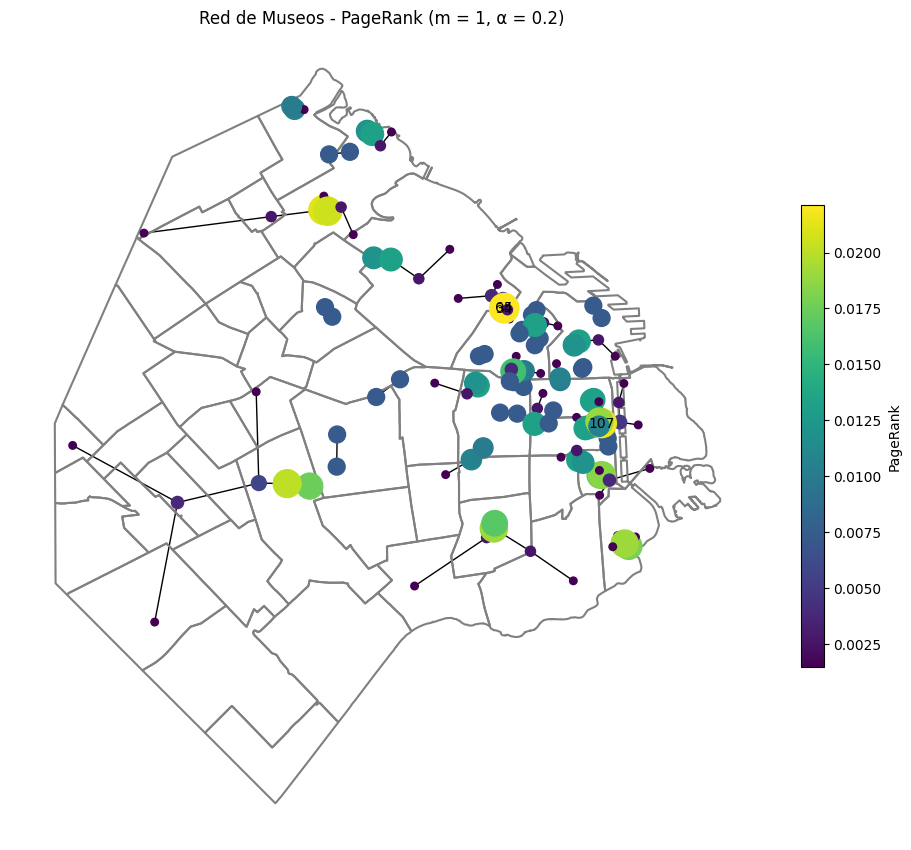

In [8]:
from scipy.linalg import solve_triangular


def calculaLU(A):

    def construir_P(A):

        n = A.shape[0]
        P = np.eye(n) # comentar aca
        A_permutada = A.copy()

        for k in range(n):
            #Tomamos los valores de la columna k desde la fila k  hasta el final
            columna = A_permutada[k:, k]

            #Hacemos que todos los valores de la columna sean su absoluto
            largo_columna_abs = np.abs(columna)

            #Buscamos el indice de la columna al que le pertenece el valor mas grande
            max_indice_columna = 0
            maxValor = largo_columna_abs[0]

            for i in range(1, len(columna)):

                if largo_columna_abs[i] > maxValor:
                    maxValor = largo_columna_abs[i]
                    max_indice_columna = i

            #Calculamos el indice correcto de la fila en A
            p = k + max_indice_columna


            # Intercambiamos filas en A_permutada y en P si es necesario
            if p != k:

                #Intercambiamos en A_copia
                A_permutada[[k, p], :] = A_permutada[[p, k], :]

                #Intercambiamos en P
                P[[k, p], :] = P[[p, k], :]

        return P, A_permutada


    P, A_permutada = construir_P(A) #Consigo la P, y en caso de que P != I la A con la filas reordenadas
    m = A.shape[0]
    n = A.shape[1]

    if m!=n:
        print('Matriz no cuadrada')
        return

    U = A_permutada # Comienza siendo una copia de A y deviene en U (triangulado superiormente)
    L = np.identity(n)  # comentar aca !!!



    for j in range(n):
        for i in range(j+1,n):
            L[i,j] = U[i,j] / U[j,j]
            U[i,:] = U[i,:] - L[i,j] * U[j,:]

    return L, U, P



# Calculo de la inversa usando descomposicion de LU para cualquier matriz inversible

def inversa_por_lu(A):
    n = A.shape[0]

    # Realizamos la factorización LU de la matriz A
    L, U, P = calculaLU(A)

    # Inicializamos la matriz identidad I
    I = np.eye(n)
    A_inv = np.zeros_like(A, dtype=float) #comentar aca !!!!

    # Resolvemos para cada columna de la matriz inversa
    for i in range(n):

        b = I[:, i]  # La columna i de la identidad

        # Resolvemos L y U
        y = solve_triangular(L, P @ b, lower=True)

        x = solve_triangular(U, y)

        A_inv[:, i] = x  # Guardamos el resultado en la columna i de A_inv

    return A_inv




def calcula_matriz_C(A):

    # Primero creo K a partir de la matriz A

    def crearK (A):

        n = A.shape[0]
        m = A.shape[1]
        K = np.zeros((m, n))
        sumaFilasA = np.sum(A, axis = 1)


        for i in range (len (sumaFilasA)):
            K[i, i] = sumaFilasA[i]

        return K

    # Nuestra matriz de transicion esta definida por A_traspuesta y K_inv, como nos pide la ecuacion (2)

    A_traspuesta = np.transpose(A) # Trasponemos A
    K = crearK(A) # Creamos K
    K_inv = inversa_por_lu(K) # Calcula inversa de la matriz K, que tiene en su diagonal la suma por filas de A
    C = A_traspuesta @ K_inv # Calcula C multiplicando A_traspuesta y K_inv

    return C



def calcula_pagerank(A,alpha):

    # Genero la matriz de transicion en base a A y una identidad en base a n de A

    n = A.shape[0]  # Dimension de A
    C = calcula_matriz_C(A)
    N = n   # Obtenemos el número de museos N a partir de la estructura de la matriz A
    I = np.eye(n)

    # Variamos la ecuacion dad, ya que tenemos una formula general para invertir con LU

    M = (N/alpha) * ( I - (1-alpha) * C )
    b = np.ones(n)  # Vector de 1s, multiplicado por el coeficiente correspondiente usando d y N.

    p = inversa_por_lu(M) @ b

    return p




# Aca variamos los datos, con m y alpha

m = 1 # Cantidad de links por nodo
alpha = 1/5 # Cantidas de conexiones

A = construye_adyacencia(D,m) # Construimos la matriz de adyacencia

page_Rank = calcula_pagerank(A, alpha) # Realizamos el calculo

page_Rank = page_Rank / np.sum(page_Rank) # Normalizamos para hacer mas viable la visualizacion


# Construccion del Mapa sin nada

fig, ax = plt.subplots(figsize=(12, 12))
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios


# Armado del mapa

factor_escala = 2e4  # Escalamos los nodos para que sean visibles "(esto puedo variar)" !!!


# Construccion del mapa de redes
G = nx.from_numpy_array(A) # Construimos la red a partir de la matriz de adyacencia

# Construimos un layout a partir de las coordenadas geográficas
G_layout = {i:v for i,v in enumerate(zip(museos.to_crs("EPSG:22184").get_coordinates()['x'],museos.to_crs("EPSG:22184").get_coordinates()['y']))}


Nprincipales = 3 # Cantidad de principales
principales = np.argsort(page_Rank)[-Nprincipales:] # Identificamos a los N principales

# Imprimir información sobre los 3 museos principales
print("Los 3 museos con mayor PageRank son:", '\n')
for i, idx in enumerate(principales[::-1]):  # Invertir para mostrar en orden descendente
    print(f"{i+1}. Museo {idx}: PageRank = {page_Rank[idx]:.6f}", '\n')

labels = {n: str(n) if i in principales else "" for i, n in enumerate(G.nodes)} # Nombres para esos nodos


# Graficamos red

nx.draw_networkx(G,G_layout,
                 node_size = page_Rank*factor_escala,
                 node_color = page_Rank,
                 cmap = plt.cm.viridis,
                 ax=ax,
                 with_labels=False)
nx.draw_networkx_labels(G, G_layout, labels=labels, font_size=10, font_color="k") # Agregamos los nombres


sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=min(page_Rank), vmax=max(page_Rank)))
sm._A = []
cbar = plt.colorbar(sm, ax=ax, shrink=0.5)
cbar.set_label("PageRank")

# Añadir título y leyenda
plt.title(f'Red de Museos - PageRank (m = {m}, α = {alpha})')
plt.axis('off')


plt.show()

#B)


###(m = 1, α = 0.2):


Los 3 museos con mayor PageRank son:

1. Museo 65: PageRank = 0.022124
2. Museo 107: PageRank = 0.021706
3. Museo 34: PageRank = 0.021288


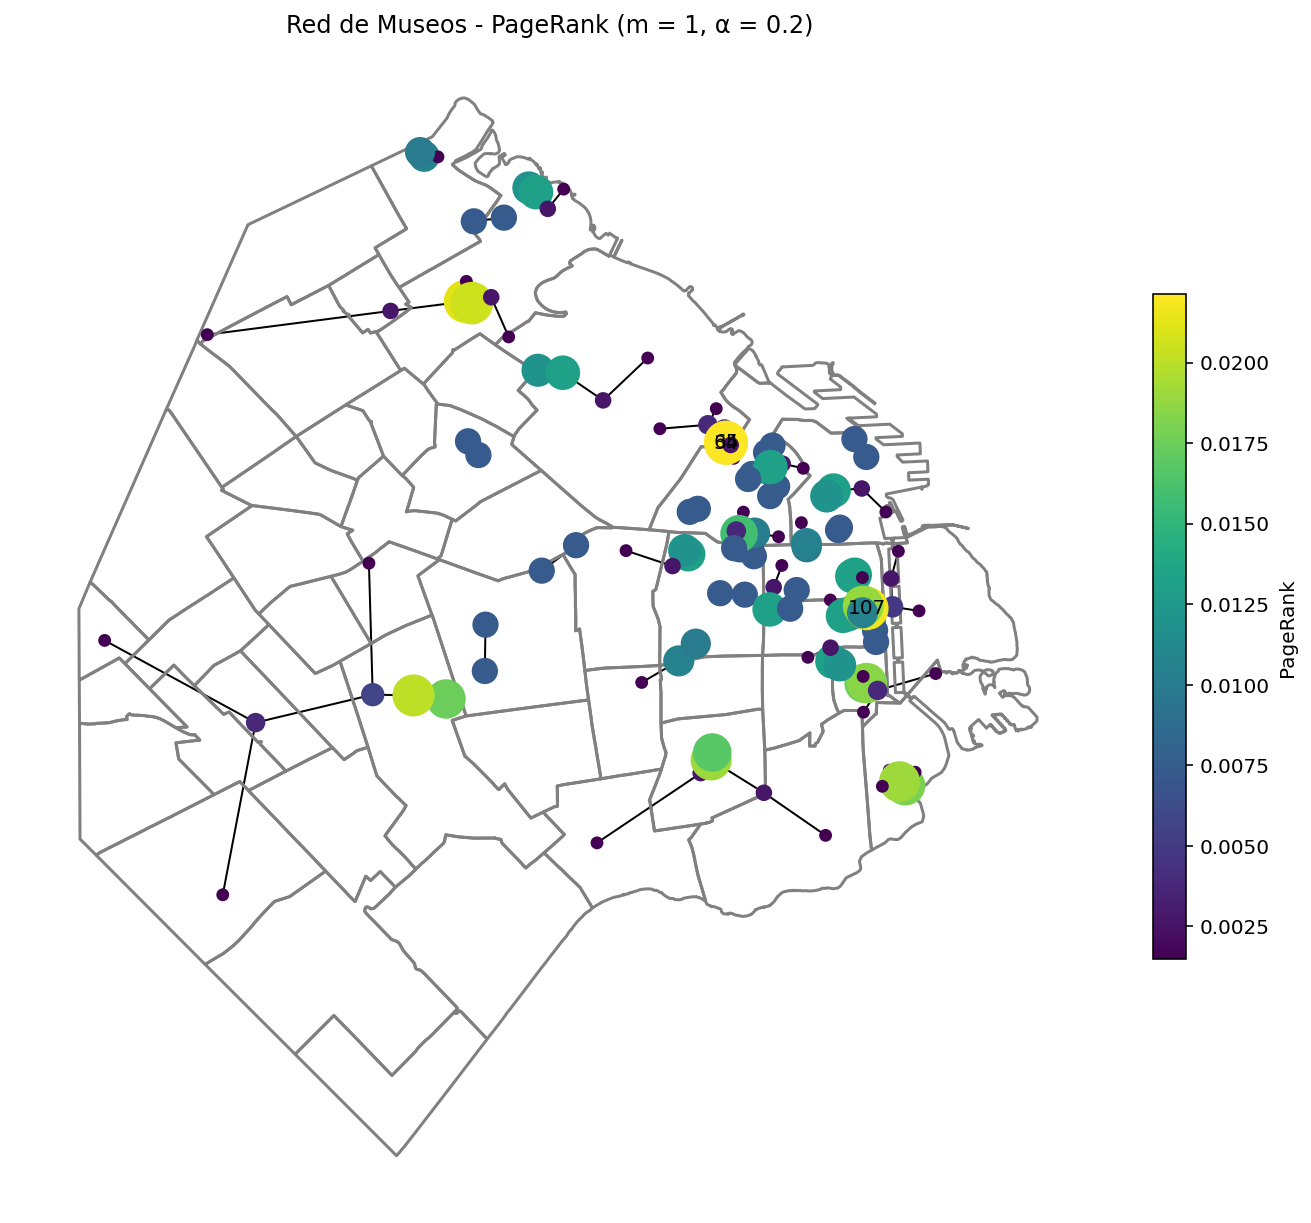

###(m = 5, α = 0.2):

Los 3 museos con mayor PageRank son:

1. Museo 93: PageRank = 0.021736
2. Museo 125: PageRank = 0.021614
3. Museo 117: PageRank = 0.021066


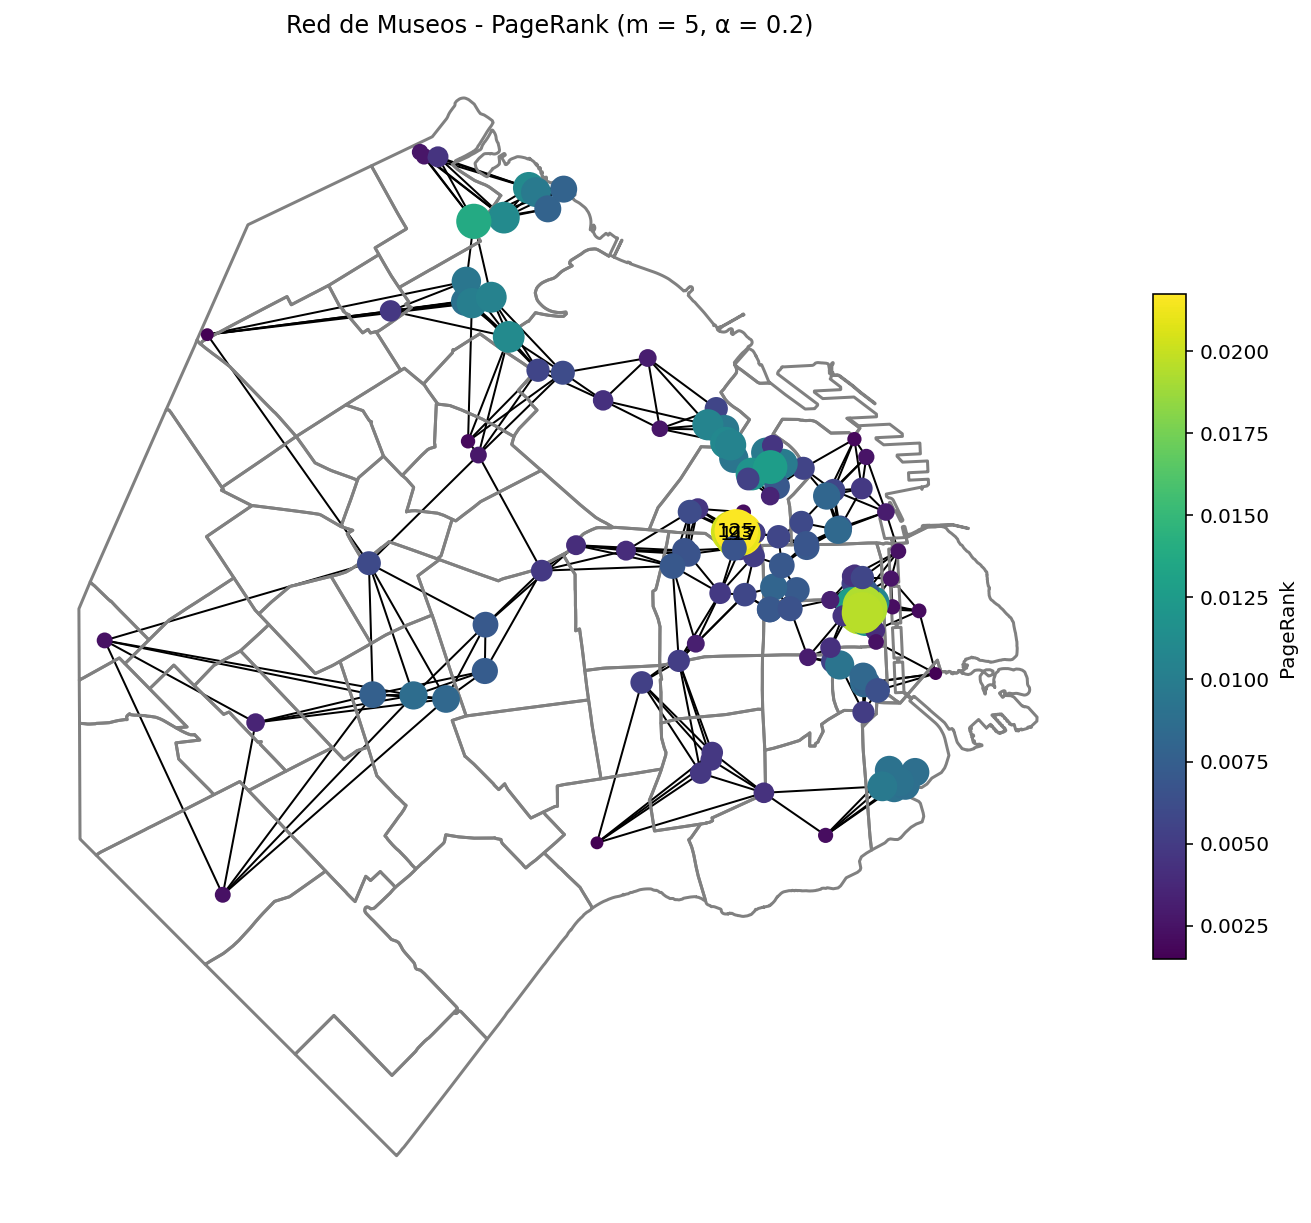

###(m = 10, α = 0.2):

Los 3 museos con mayor PageRank son:

1. Museo 124: PageRank = 0.018665
2. Museo 135: PageRank = 0.018338
3. Museo 15: PageRank = 0.018291




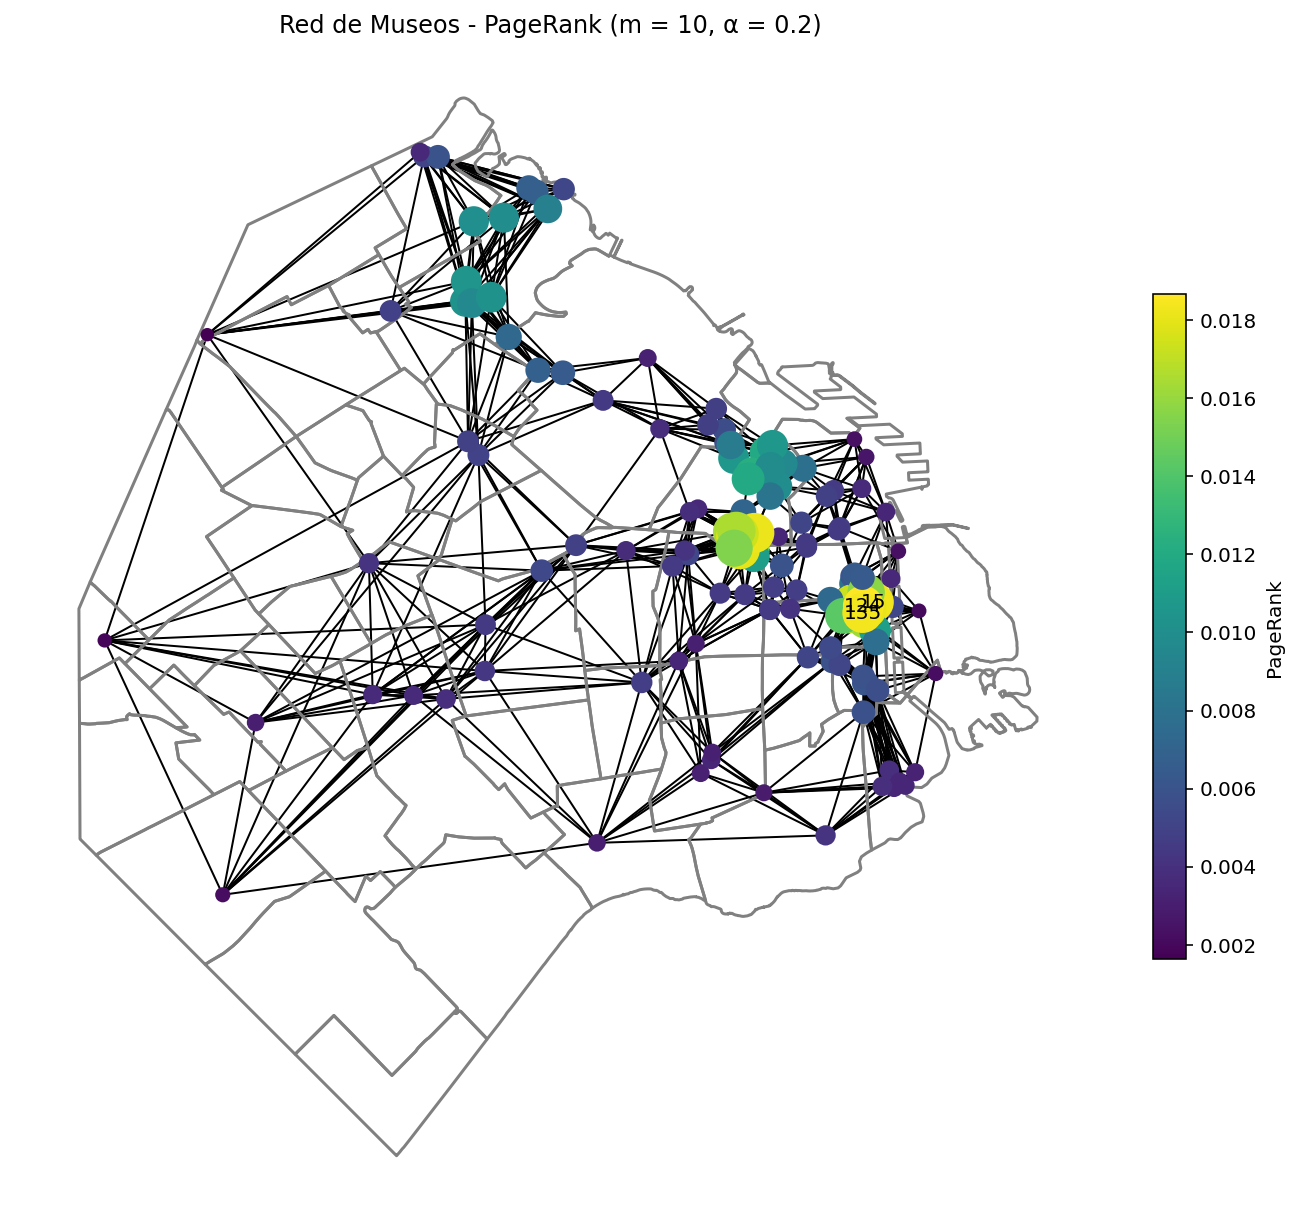

#C)


###(m = 5, α = 6/7):

Los 3 museos con mayor PageRank son:

1. Museo 107: PageRank = 0.008681
2. Museo 135: PageRank = 0.008496
3. Museo 18: PageRank  = 0.008496



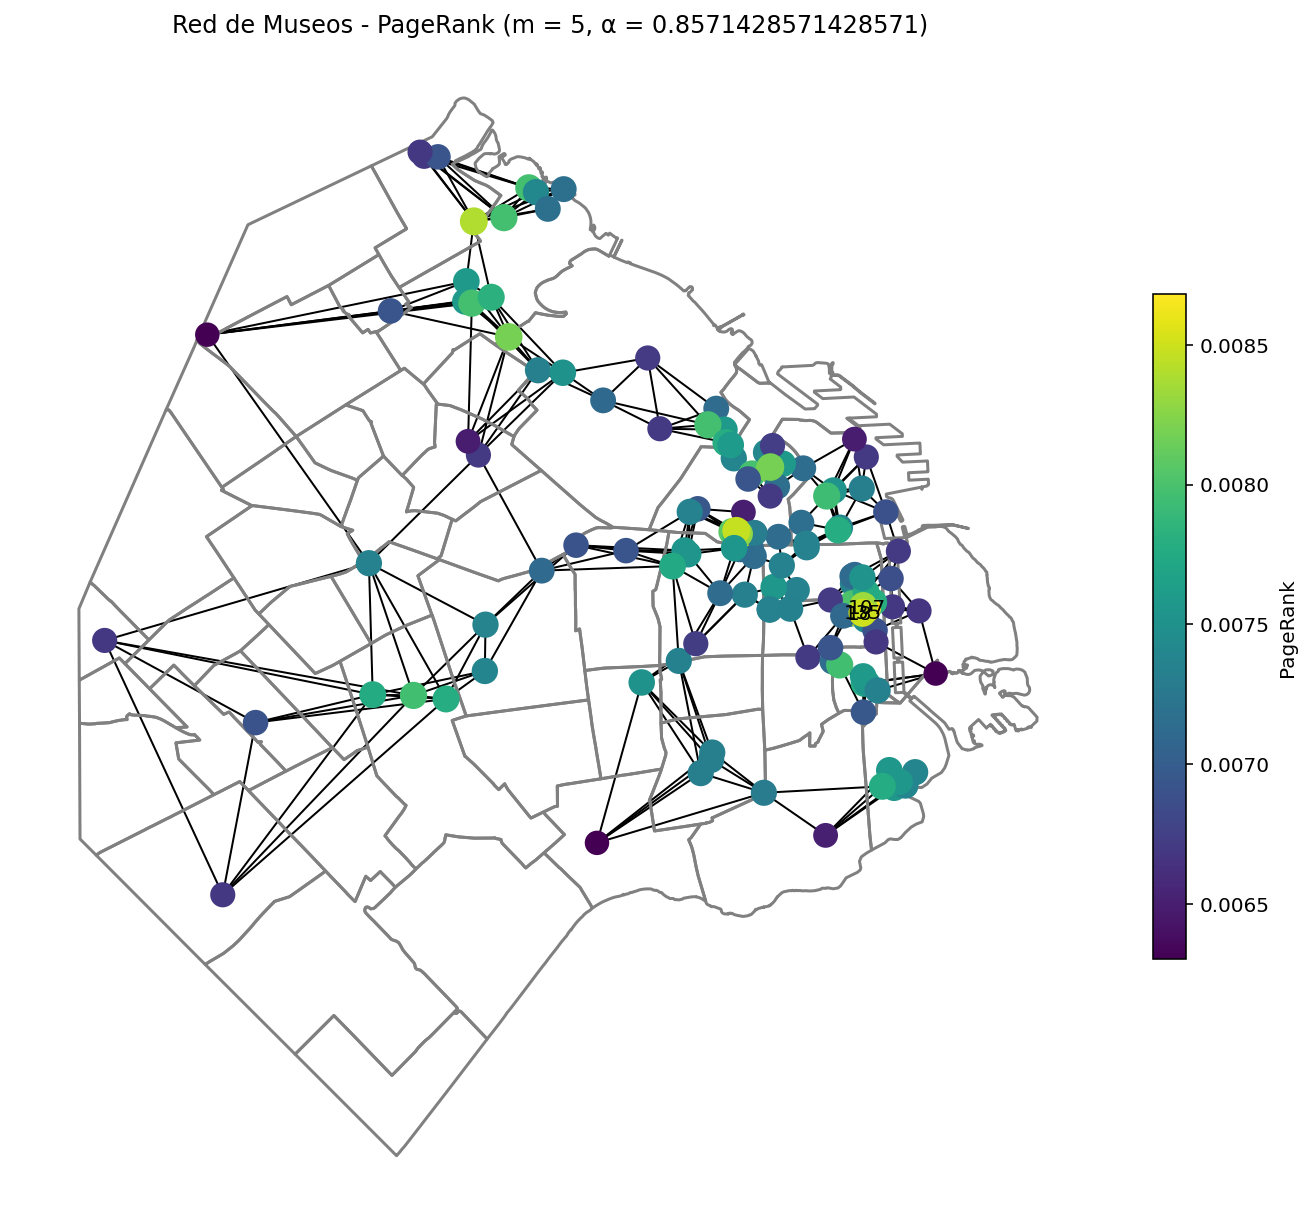

###(m = 5, α = 4/5):

Los 3 museos con mayor PageRank son:

1. Museo 107: PageRank = 0.009256
2. Museo 135: PageRank = 0.009013
3. Museo 18: PageRank = 0.009013

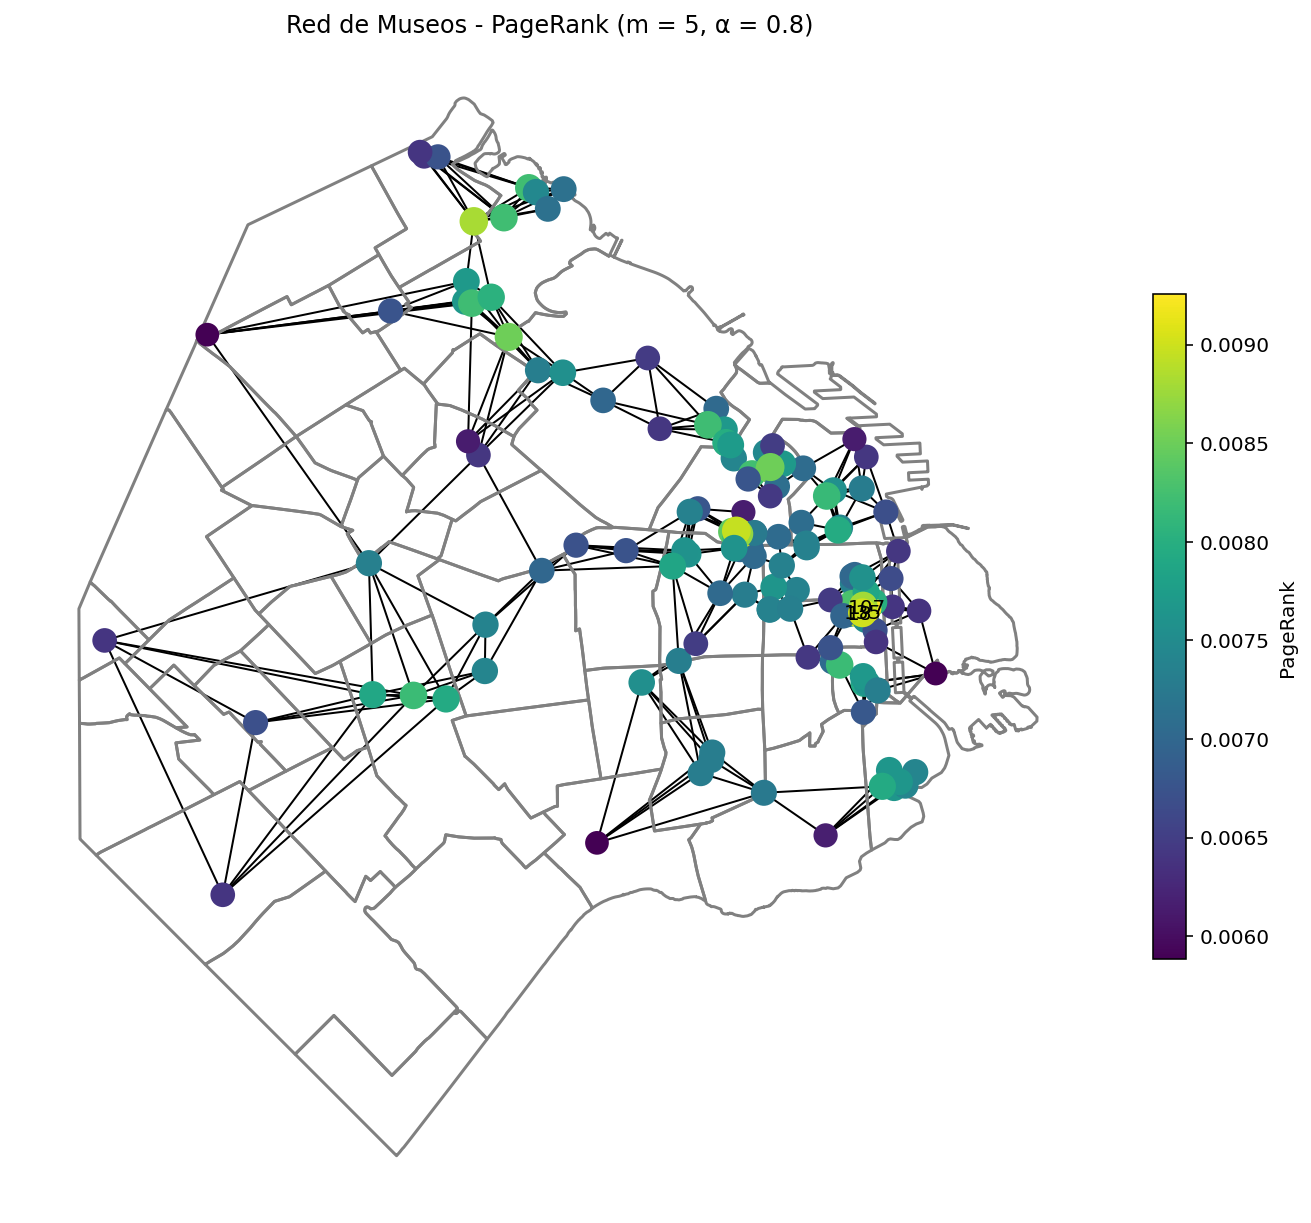

###(m = 5, α = 2/3):

Los 3 museos con mayor PageRank son:

1. Museo 107: PageRank = 0.010727
2. Museo 18: PageRank = 0.010390
3. Museo 135: PageRank = 0.010390

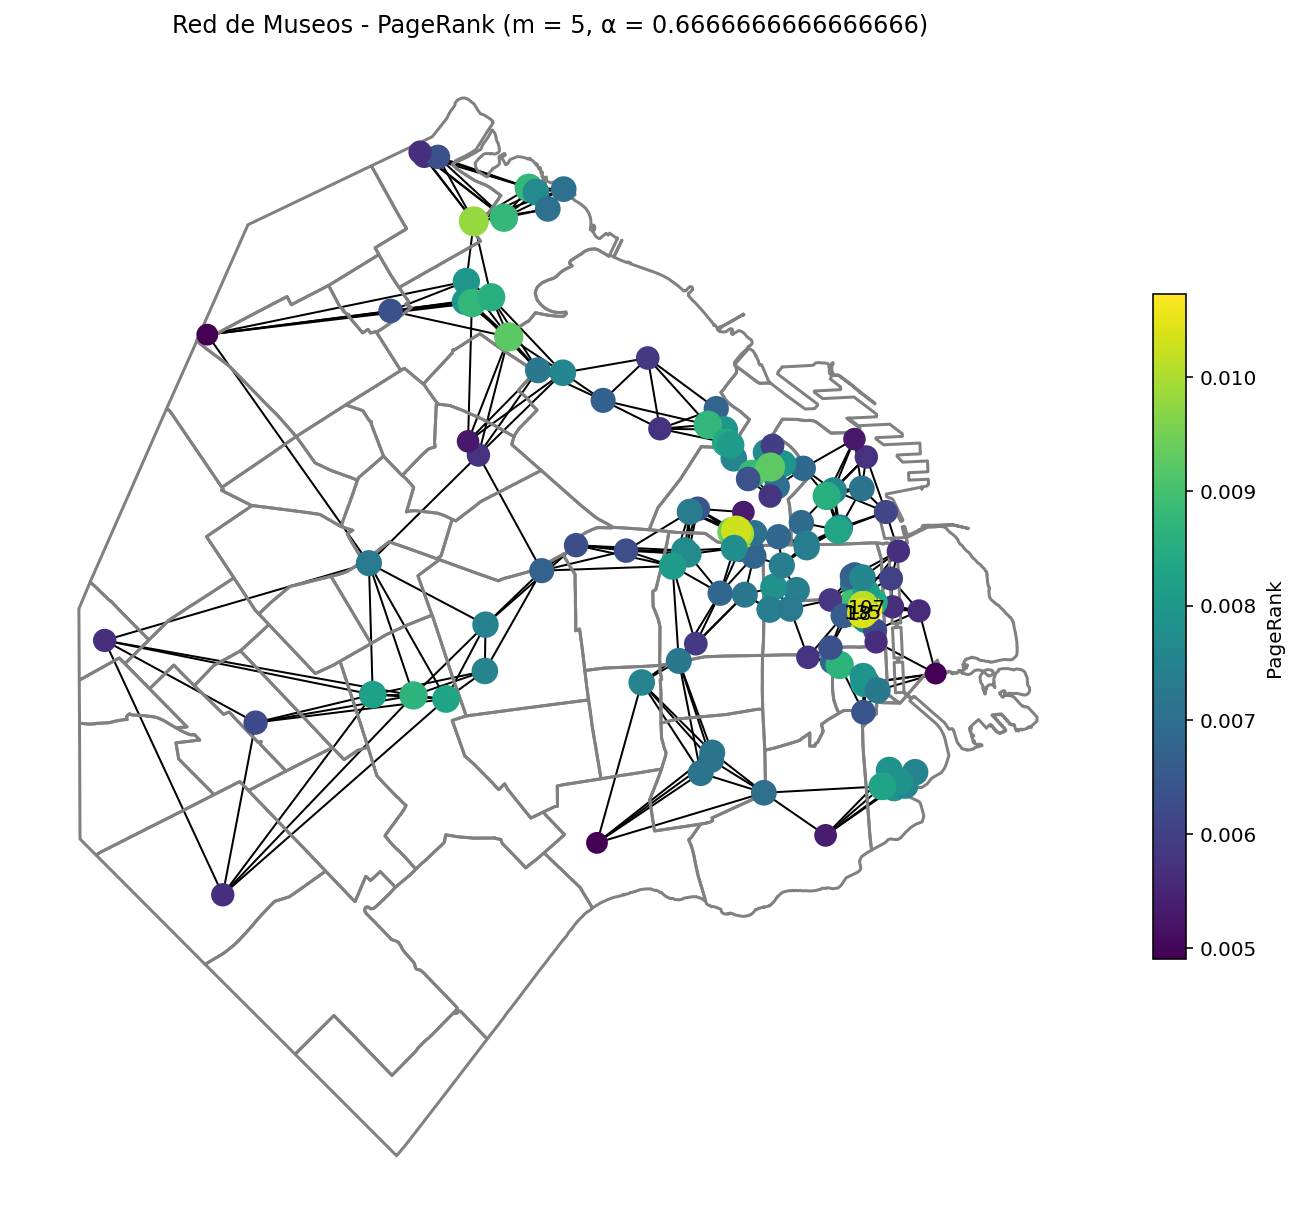

###(m = 5, α = 1/2):

Los 3 museos con mayor PageRank son:

1. Museo 107: PageRank = 0.012931
2. Museo 93: PageRank = 0.012601
3. Museo 135: PageRank = 0.012585

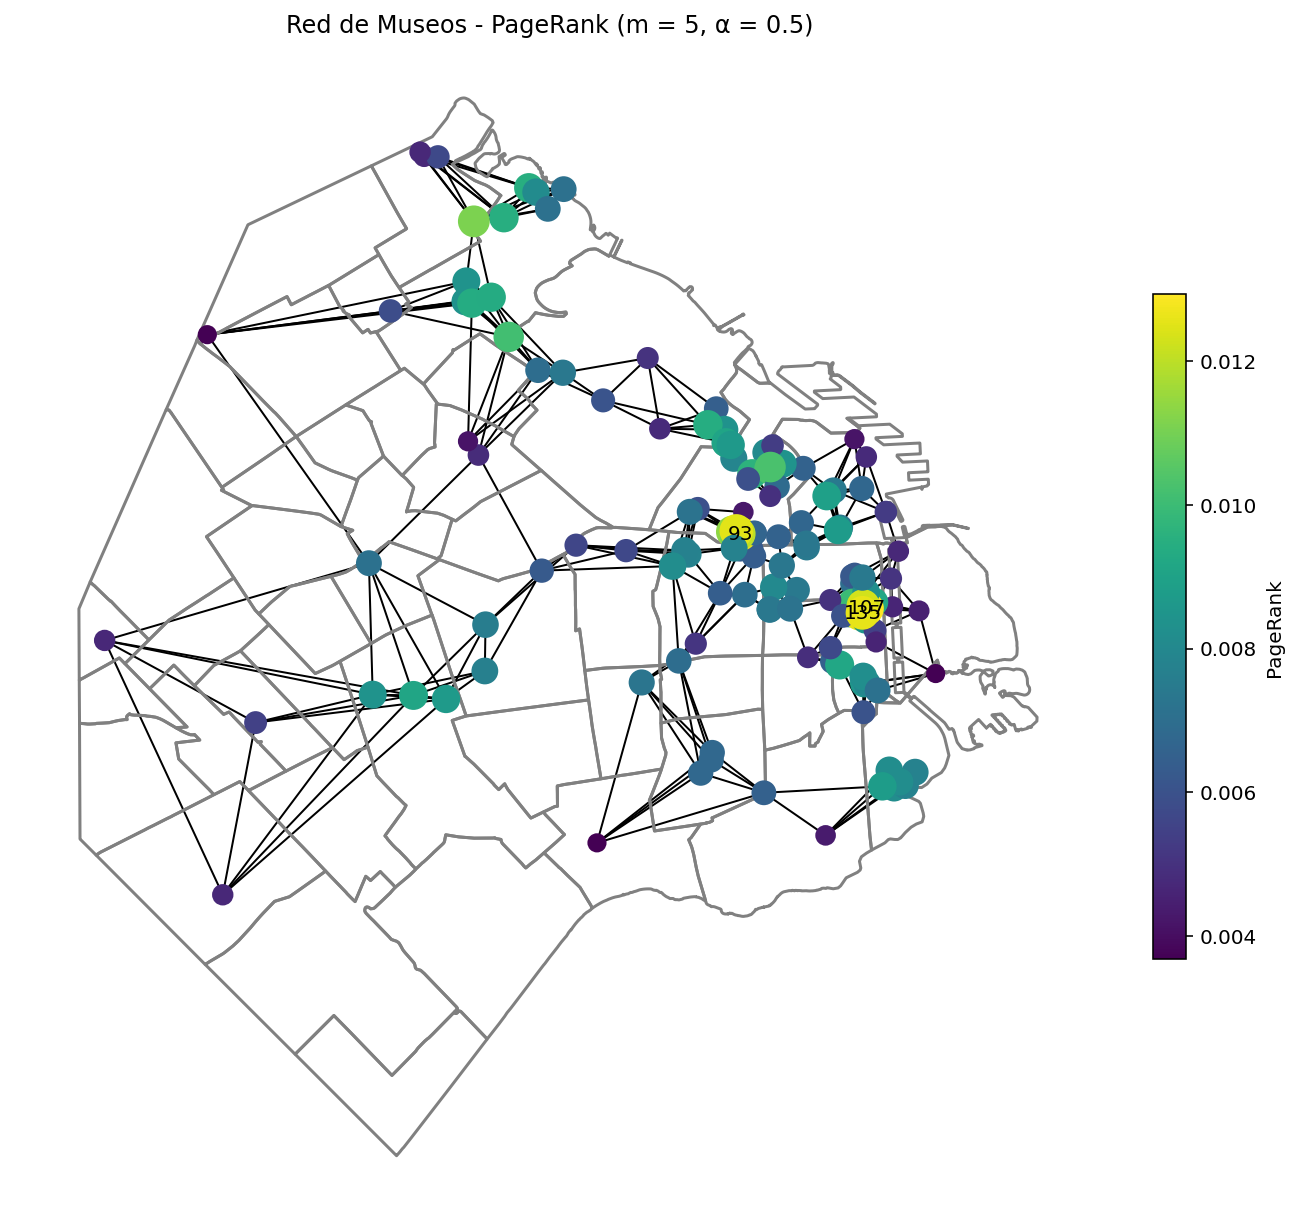

###(m = 5, α = 1/3):

Los 3 museos con mayor PageRank son:

1. Museo 93: PageRank = 0.016230
2. Museo 125: PageRank = 0.016112
3. Museo 107: PageRank = 0.015848



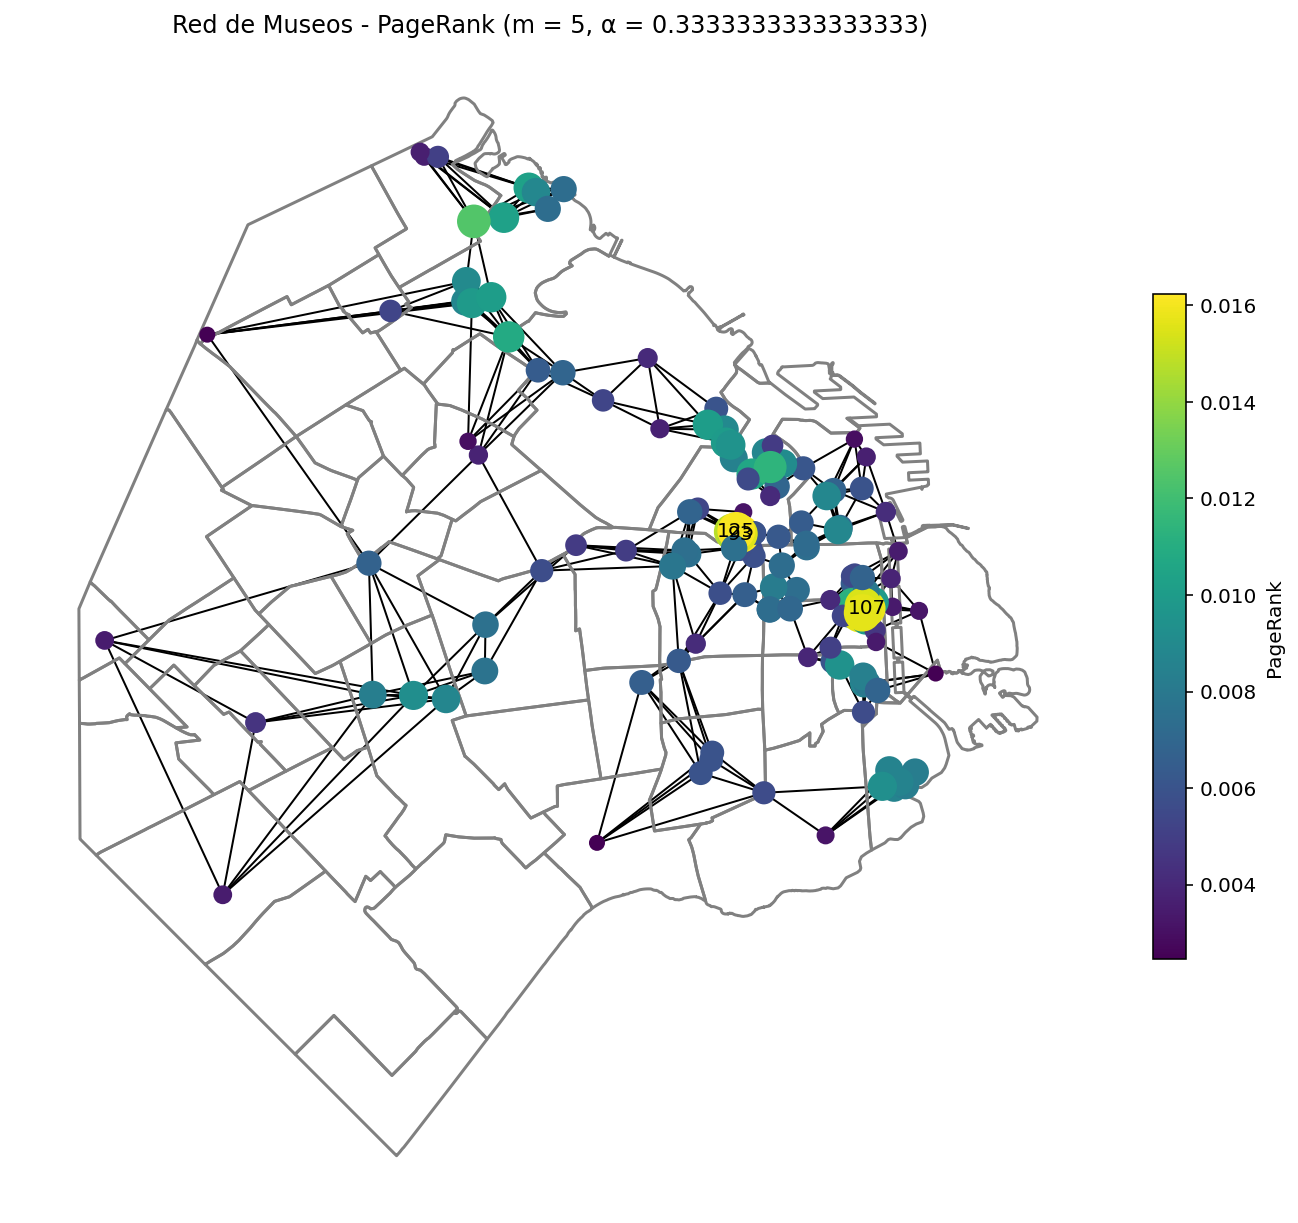


###(m = 5, α = 1/7):

Los 3 museos con mayor PageRank son:

1. Museo 93: PageRank = 0.025896
2. Museo 125: PageRank = 0.025781
3. Museo 117: PageRank = 0.025274


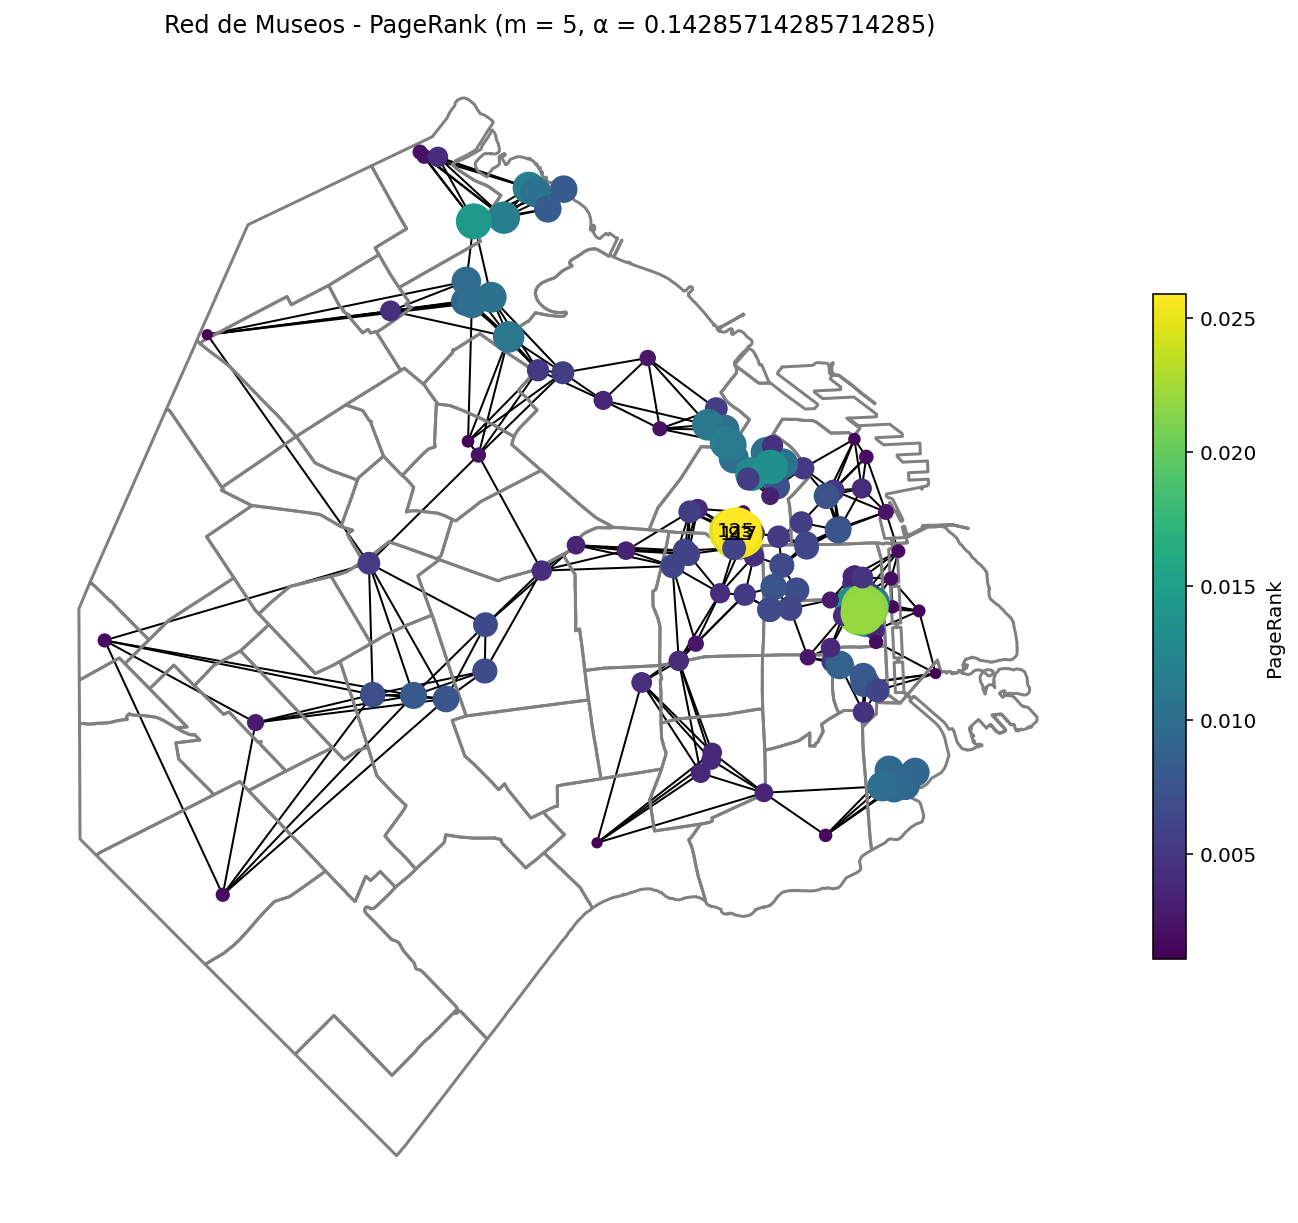

#A)

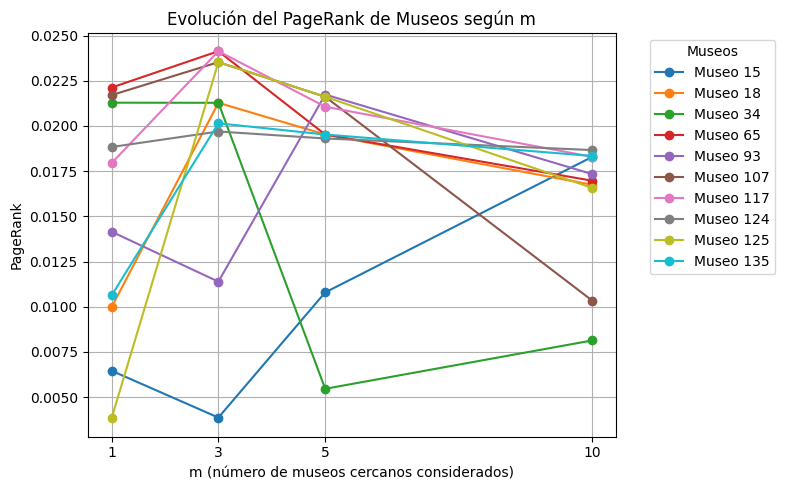

In [9]:
import numpy as np
import matplotlib.pyplot as plt

m_values = [1, 3, 5, 10]

# Hago un dict de los page rank de los museos con mayor promedio para todos los m

page_rank = {
    15 : [0.006458, 0.003866, 0.010792, 0.018291],
    18 : [0.009967, 0.021280, 0.019525, 0.016743],
    34 : [0.021287, 0.021280, 0.005459, 0.008134],
    65 : [0.022124, 0.024135, 0.019525, 0.016970],
    93 : [0.014150, 0.011385, 0.021736, 0.017335],
    107: [0.021705, 0.023529, 0.021614, 0.010335],
    117: [0.017941, 0.024135, 0.021065, 0.018290],
    124: [0.018835, 0.019692, 0.019307, 0.018665],
    125: [0.003823, 0.023529, 0.021614, 0.016571],
    135: [0.010620, 0.020145,  0.019525, 0.018338]


}


plt.figure(figsize=(8, 5))

for museo_id, valores in page_rank.items():
    plt.plot(m_values, valores, marker='o', label=f'Museo {museo_id}')

plt.title('Evolución del PageRank de Museos según m')
plt.xlabel('m (número de museos cercanos considerados)')
plt.ylabel('PageRank')
plt.xticks(m_values)
plt.grid(True)
plt.legend(title='Museos', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()


plt.show()

#(Faltaria ver si tamb hay que hacer un grafico en funcion de alpha)


#B)

De los graficos realizados para el punto 3b y 3c podemos sacar las siguientes conclusiones:
  - Al aumentar m los museos mas alejados disminuyen sustancialmente su valor de page rank. Mientras que los museos mas centricos se mantienen dentro del podio, aunque tambien con un valor mas bajo.

  - Cuanto mas grande sea el alpha, menor sera el page rank (Che, esto no es asi !del todo!, mas bien al contrario, cuanto menor el alpha, mayor el page rank, porque si bien disminuye un poco el C al amortiguarlo (en I -(1-α)C), tambien es un factor que multiplica por fuera, ya que nos queda N/α que al ser un vector fraccional en su mayoria, pasa a estar multiplicando por el total de museos, lo que hace la multiplicacion groseramente mas grande (136/(1/10) = 136 * 10).
  
  Esto aplica para tanto para los museos centricos como para los alejados. Si bien el podio se mantiene en la zona centrica, con los valores de alpha mas altos la diferencia entre el page rank de los museos centricos y los alejados disminuye en gran medida.

# Punto 4: TERMINADO

##Resolucion

El enunciado nos brinda informacion muy relevante a la hora de resolver el ejercicio. Sabemos que:

&nbsp;

$$ r \; = \; \text {cantidad de museos visitados por cada persona} \\[12pt]$$
$$ w \; = \; \text {vector que representa el numero total de visitantes de cada museo} \\ \; w_i \; = \; \text {cantidad de visitantes totales del museo } i \\[12pt]$$
$$ v \; = \; \text {numero de personas totales que inician en cada museo} \\ v_i \; = \; \text {numero de personas totales que inician en el museo } i \\[12pt]$$
$$ B \; = \; \sum_{k=0}^{r-1} C^k \\[12pt]$$
$$ C \; = \; \text{Matriz de Transiciones} \\[10pt]$$

En base al "Tip" del enunciado:

"si v da el número de visitantes que entraron a la red en cada museo, entonces luego de k pasos podemos esperar la distribución C^k·v sobre el total de museos"

Entonces,

&nbsp;

$$ v \; = \; \text {vector inicial de visitantes (r = 1)} \\[8pt]$$
$$ C \; \cdot \; v \; = \; \text{distribucion de viistantes tras un paso (r = 2)} \\[8pt]$$
$$ C \, ^2 \; \cdot \; v \; = \; \text{distribucion de viistantes tras dos pasos (r = 3)} \\[8pt]$$
$$ C \, ^{r-1} \; \cdot \; v \; = \; \text{distribucion de visitantes tras r - 1 pasos} \\[8pt]$$

Por lo tanto el numero de visitantes de $w$ sera la suma de todos estos vectores, llegando asi al numero total. De forma:

&nbsp;

$$ w \; = \; v \; + \; C \cdot v \; + \; C \, ^2 \cdot v \; + \; ... \; + \; C \, ^{r-1} \cdot v \; \\[8pt]$$
$$ \text {Esto puede ser escrito como:} \\[8pt]$$
$$ w \; = \; \left(\; I \; + \; C \; + \; C \, ^2 \; + \; ... \; + \; C \, ^{r-1}\; \right) \cdot v \\[8pt]$$
$$ w \; = \; (\; \sum_{k=0}^{r-1} C\,^k \; ) ⋅ v$$

Donde $I$ es la matriz identidad, por $C\, ^0$

Con la definicion de $B$ tenemos entonces que:

&nbsp;

$$ w \; = \; B \; \cdot \; v \\[10pt]$$

Despejamos para encontrar $v$ en terminos de $w$ tal que:

&nbsp;

$$ v \; = \; B \, ^{-1} \; \cdot \; w \\[8pt]$$

Demostrando entonces lo que nos pedian



# Punto 5: TERMINADO


In [10]:
def sumfila(F, i):
        res = 0
        N = F.shape[0]

        for k in range(1,N):
            if k!= i:
                res = res + F[i,k]

        return res

def calcula_matriz_C_continua(D):
    N = D.shape[0]

    D = D.copy()
    np.fill_diagonal(D, np.inf)
    F = 1/D
    np.fill_diagonal(F,0)
    Kinv = np.zeros((N,N))

    for i in range(N):
              Kinv[i,i] = sumfila(F, i)

    C = Kinv @ F
    return C

def calcula_B(C,r):
    n = C.shape[0]
    B = np.eye(n)

    for k in range(r):
        C_elevada_k = np.linalg.matrix_power(C,k)
        B = B + C_elevada_k

    return B


r = 3
C = calcula_matriz_C_continua(D)
B = calcula_B(C,r)

B_inversa = inversa_por_lu(B)


visitas = [1159, 1078, 1137, 1073, 1097, 1083, 1096, 1088, 1126, 1083, 1151, 1105, 1110, 1102, 1110, 1170, 1084, 1120, 1120, 1106, 1160, 1146, 1073, 1087, 1056, 1113, 1149, 1082, 1088, 1053, 1115, 1115, 1146, 1133, 1137, 1090, 1092, 1031, 1085, 1103, 1077, 1128, 1172, 1116, 1130, 1085, 1013, 1173, 1120, 1081, 1116, 1052, 1118, 1070, 1087, 1089, 1125, 1034, 1105, 1124, 1117, 1090, 1103, 1163, 1076, 1086, 1063, 1138, 1120, 1085, 1053, 1105, 1128, 1094, 1084, 1123, 1052, 1070, 1069, 1119, 1194, 1085, 1124, 1089, 1101, 1090, 1096, 1176, 1115, 1061, 1134, 1049, 1097, 1069, 1068, 1081, 1094, 1075, 1110, 1129, 1115, 1086, 1083, 1128, 1097, 1124, 1100, 1118, 1073, 1121, 1127, 1126, 1086, 1073, 1060, 1083, 1077, 1037, 1072, 1046, 1161, 1138, 1104, 1108, 1086, 1081, 1094, 1131, 1116, 1116, 1168, 1115, 1110, 1118, 1156, 1124]

W = np.array(visitas)


V = B_inversa @ W

t = B @ V

res = np.linalg.norm(V,1)

y = np.sum(W)
x = np.sum(t)

print(V)
print(res)
print(np.array_equal(x, y))

print( "W :" , W)
print("t : ", t)

[577.24264713 538.65682613 566.48530737 535.88394111 548.22287772
 540.78942892 546.69655657 529.68710754 562.8033204  540.92708502
 574.85946484 551.50773675 554.60447757 550.01100531 553.90008736
 583.09016518 539.51158329 559.02617571 556.793979   552.74963525
 579.74946178 571.35127787 536.05811707 542.4707999  526.79040012
 555.20055444 574.44722996 540.83244265 543.76242442 526.14186128
 557.31932492 557.19507357 572.16287332 565.34289099 562.29983914
 543.34572086 545.81624554 515.46096371 541.39398234 550.75429918
 536.37384599 562.47107578 584.42697632 556.36158497 563.96091881
 542.00567326 506.0596991  585.36871798 558.89463865 540.24753814
 557.87817533 524.16639732 558.77565439 534.78427737 542.89239025
 544.24603114 561.86505676 516.79213863 551.20906475 560.58085132
 558.46078411 542.8777328  550.91334934 580.29887612 535.75234714
 536.73971021 530.38168189 567.87106196 559.47690118 540.6091229
 525.1756674  525.37672104 561.56978532 545.93124003 514.48609783
 560.617613

# Punto 6: TERMINADO

La ecuacion (6) del enunciado:

&nbsp;

$$ \frac{\|v - \tilde{v}\|_1}{\|v\|_1} \leq \text{cond}_1(B) \cdot \frac{\|w - \tilde{w}\|_1}{\|w\|_1} \\[10pt]$$

Nos dice que el error relativo de la solucion $v \,$ (el total de primeras visitas respectivamanete), esta acotado superiormente por el error relativo de los datos de $w \,$ multiplicado por el numero de condicion  $B \,$ de norma 1.

Como sabemos los datos de visitas tienen un error del 5% es decir:

&nbsp;
$$ \frac{\|w - \tilde{w}\|_1}{\|w\|_1} \; = \; 0.05\\[10pt] $$

Esto implica que el error relativo maximo de $v \,$ es:

&nbsp;
$$ v \; = \; \text{cond}_1(B) \cdot 0.05 \\[10pt]$$

Calculamos el numero de condicion de B y luego la cota para el error de estimacion de v.

Donde el numero de condicion esta dado por la formula:

&nbsp;
$$ \text{cond}_1(B) = \|B\|_1 \cdot \|B\;^{-1}\|_1$$

In [13]:
def nro_condicion_norma1(B):

    B_inv = inversa_por_lu(B)

    norma1_de_B = np.linalg.norm(B, 1)
    norma1_de_B_inv = np.linalg.norm(B_inv, 1)

    return norma1_de_B * norma1_de_B_inv

r = 3 # Calculamos sobre la misma cantidad que en el ejercicio 5
C = calcula_matriz_C_continua(D) # Hacemos C en base a lo obtenido del ejercicio y trabajamos con la matriz de distancias
B = calcula_B(C,r)

condB = nro_condicion_norma1(B)

print(condB * 0.05)


0.05427756656367645


# Extras

Para graficar la red con un conjunto de puntajes (como el Page Rank)

{0: Text(4924405.086723215, 6160838.106023658, ''),
 1: Text(4917216.80489522, 6166701.553530234, ''),
 2: Text(4924486.298584606, 6161409.256658559, ''),
 3: Text(4921922.052887296, 6164690.544542129, ''),
 4: Text(4920636.67547965, 6165640.199444978, ''),
 5: Text(4925338.320928778, 6162016.528710163, ''),
 6: Text(4922856.100832731, 6163868.567721188, ''),
 7: Text(4922641.894255253, 6162355.100129171, ''),
 8: Text(4917938.7521918025, 6168273.372961773, ''),
 9: Text(4924683.52693892, 6158996.617208998, ''),
 10: Text(4925725.9600755945, 6160896.846339954, ''),
 11: Text(4922075.10183836, 6164294.738410278, ''),
 12: Text(4926038.146946977, 6159721.190876993, ''),
 13: Text(4925200.592014585, 6161503.005610317, ''),
 14: Text(4925229.168803978, 6160973.145341254, ''),
 15: Text(4924875.410406244, 6161061.981187101, ''),
 16: Text(4924474.294424794, 6161547.549492302, ''),
 17: Text(4923553.755484842, 6163571.336254905, ''),
 18: Text(4924615.955668659, 6160843.2491330765, ''),
 19:

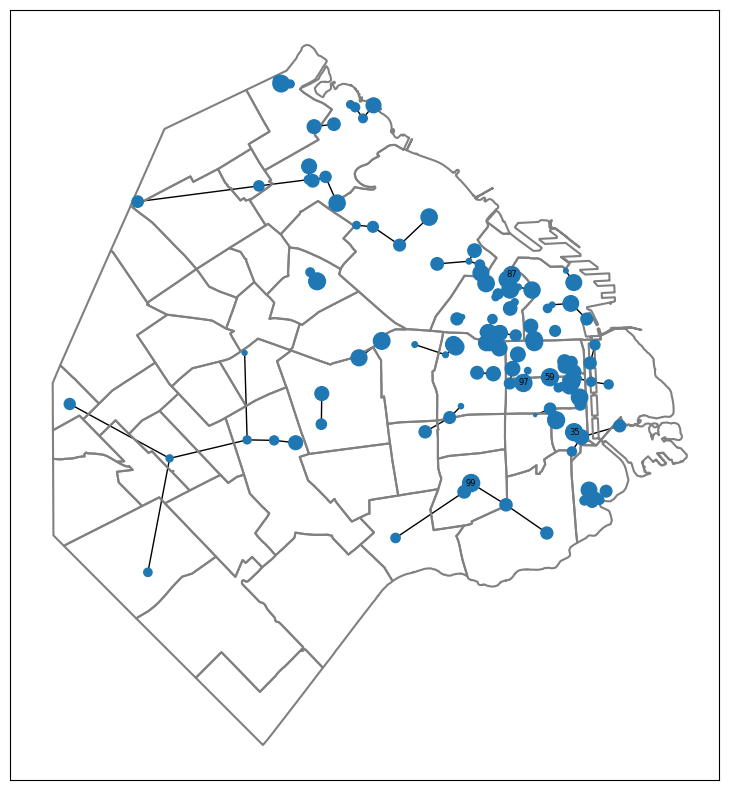

In [12]:
factor_escala = 1e4 # Escalamos los nodos 10 mil veces para que sean bien visibles
fig, ax = plt.subplots(figsize=(10, 10)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
pr = np.random.uniform(0,1,museos.shape[0])# Este va a ser su score Page Rank. Ahora lo reemplazamos con un vector al azar
pr = pr/pr.sum() # Normalizamos para que sume 1
Nprincipales = 5 # Cantidad de principales
principales = np.argsort(pr)[-Nprincipales:] # Identificamos a los N principales
labels = {n: str(n) if i in principales else "" for i, n in enumerate(G.nodes)} # Nombres para esos nodos
nx.draw_networkx(G,G_layout,node_size = pr*factor_escala, ax=ax,with_labels=False) # Graficamos red
nx.draw_networkx_labels(G, G_layout, labels=labels, font_size=6, font_color="k") # Agregamos los nombres